In [1]:
# A3 
# independently by Shao Shi
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

In [2]:
# Q1
GHGdata = xr.open_dataset("200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc", engine="netcdf4")

In [3]:
# 1.1
xch4Monthly = GHGdata.xch4.groupby('time.month').mean(dim='time')
# Plot 12 figures:

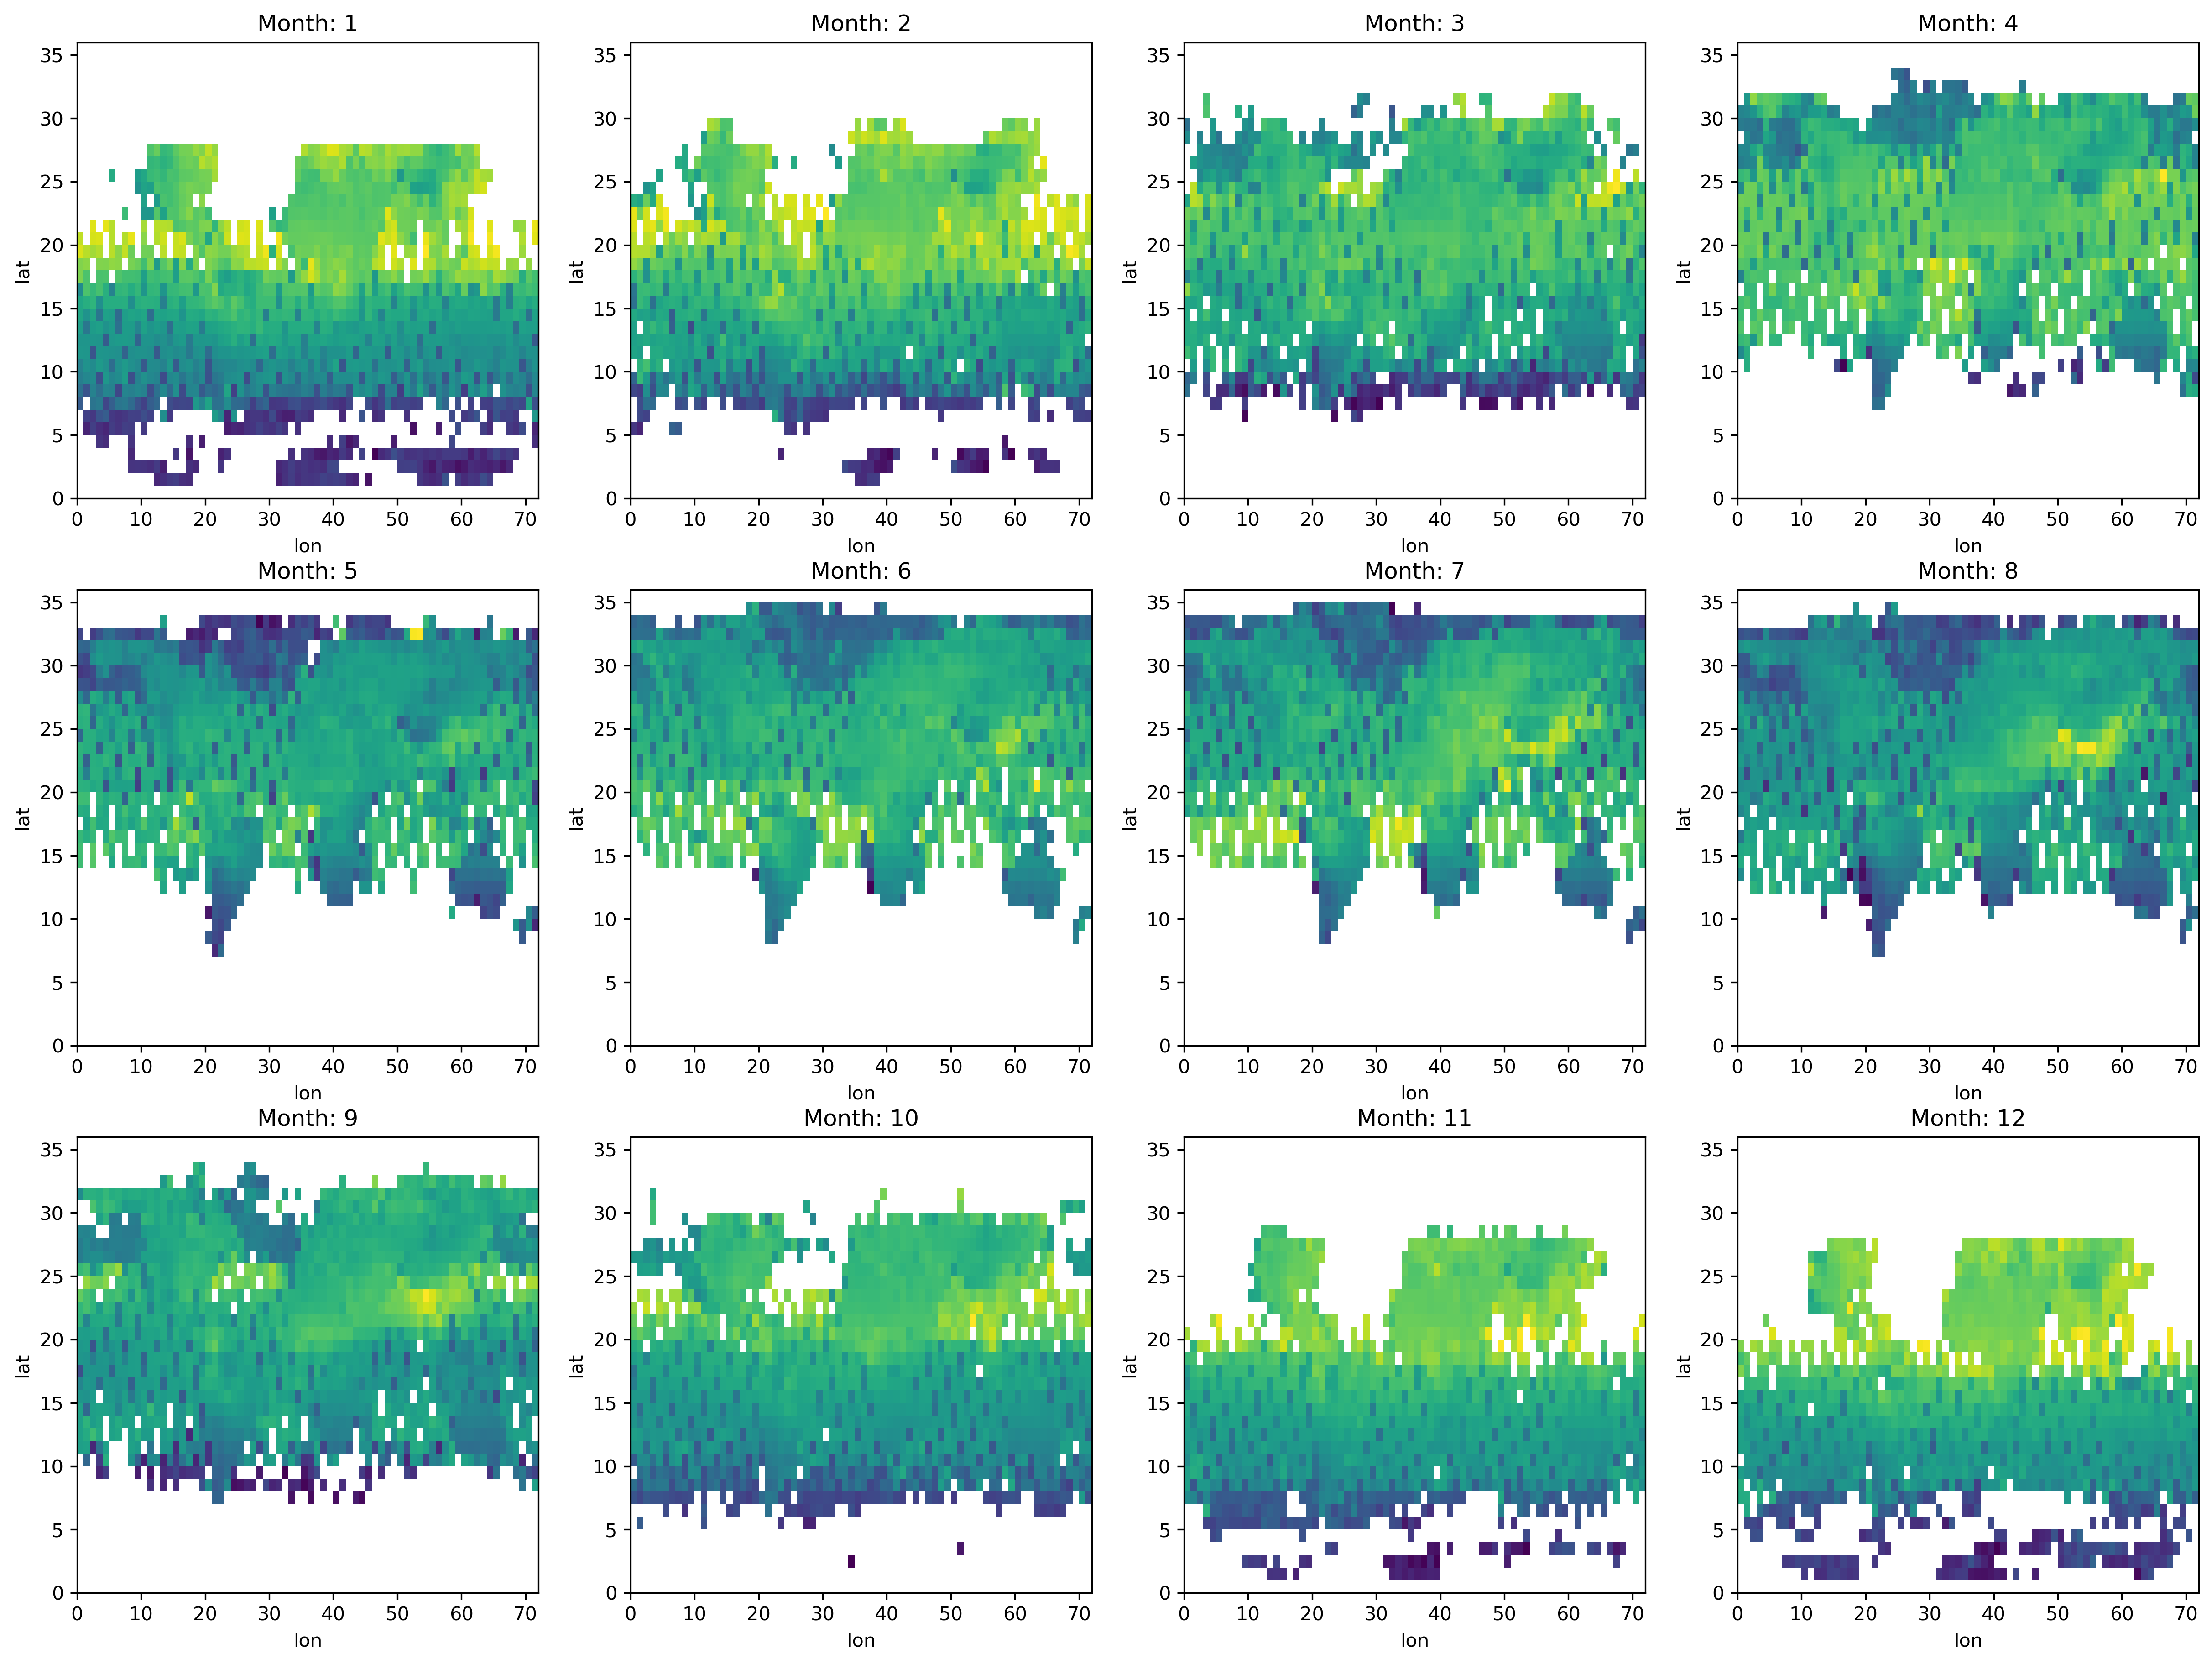

In [4]:
# Method 1
# this method have some axis problem, to be solved
fig, axes = plt.subplots(3,4, figsize=(20,15), sharey=False, dpi=300)
for i in range(3):
    for j in range(4):
        axes[i,j].set_title('Month: ' + str(4*i+j+1))
        axes[i,j].set_xlabel('lon')
        axes[i,j].set_ylabel('lat')
        axes[i,j].pcolormesh(xch4Monthly[4*i+j,:,:])

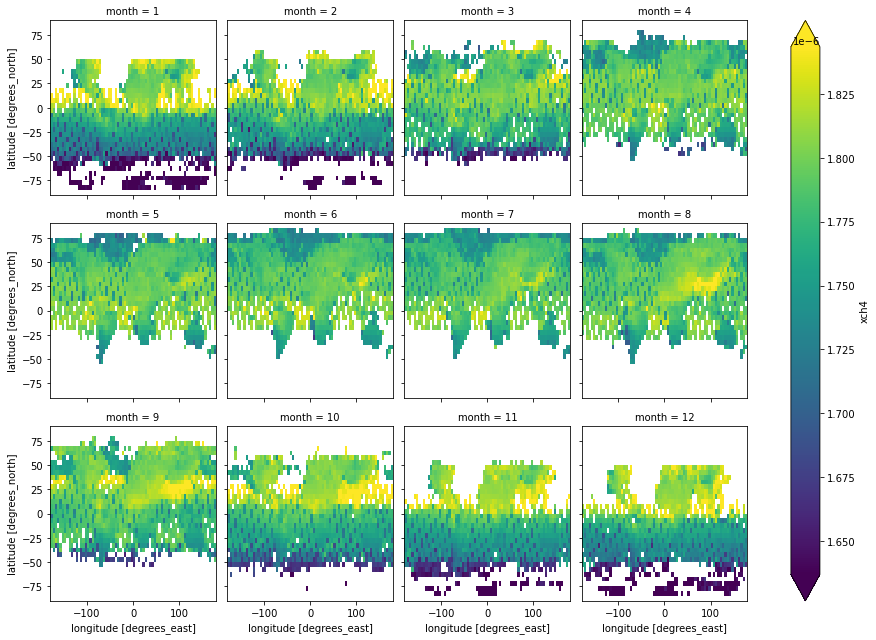

In [5]:
# Method 2
# this method is fine
xch4Monthly.plot(col='month', col_wrap=4, robust=True)
plt.show()

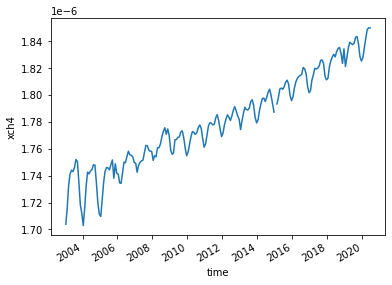

In [6]:
# 1.2
xch4Global = GHGdata.xch4.mean(dim=('lon', 'lat')).sel(time=slice("2003-01", "2020-06"))
xch4Global.plot()
# The methane concentration is increasing.
# The global averaged methane level also possesses a obvious seasonal trend, 
# this trend is in accordance as the one from the website, 
# although there are some years, such as 2004,
# in which the two plots seems to have different methane values

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


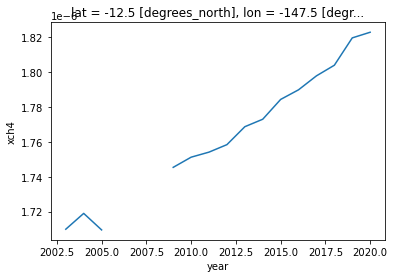

In [7]:
# 1.3
# Since there are many missing values in the time series, we cannot use the following function to decompose it
'''
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(xch4Point, model="additive")
decompose_data.plot(); 
'''
# Therefore, I use the yearly averaged values instead
xch4Point = GHGdata.xch4.sel(time=slice("2003-01", "2020-06")).sel(lon=-150, lat =-15, method='nearest')
xch4Point.groupby('time.year').mean().plot()
# the result shows that the methane level is obviously increasing at this point

In [8]:
# Q2
SSTdata = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc", engine="netcdf4")
print(SSTdata)

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...


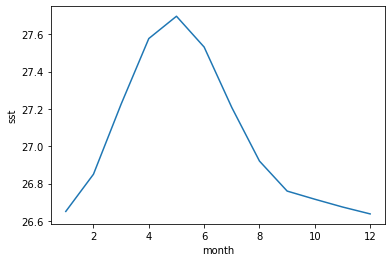

In [9]:
# 2.1
SSTdataNino = SSTdata.sel(lon=slice(190, 240), lat=slice(-5, 5)).mean(dim=('lon','lat'))
sstNinoRolling = SSTdataNino.sst.rolling(time=3, center=True).mean()
sstNinoRollingMonthlyGroups = sstNinoRolling.groupby('time.month')
# monthly climatology
sstNinoRollingMonthlyGroups.mean(dim='time').plot()
# obtain anomalies
sst_anom = sstNinoRollingMonthlyGroups - sstNinoRollingMonthlyGroups.mean(dim=('time'))
# show monthly climatology
plt.show()

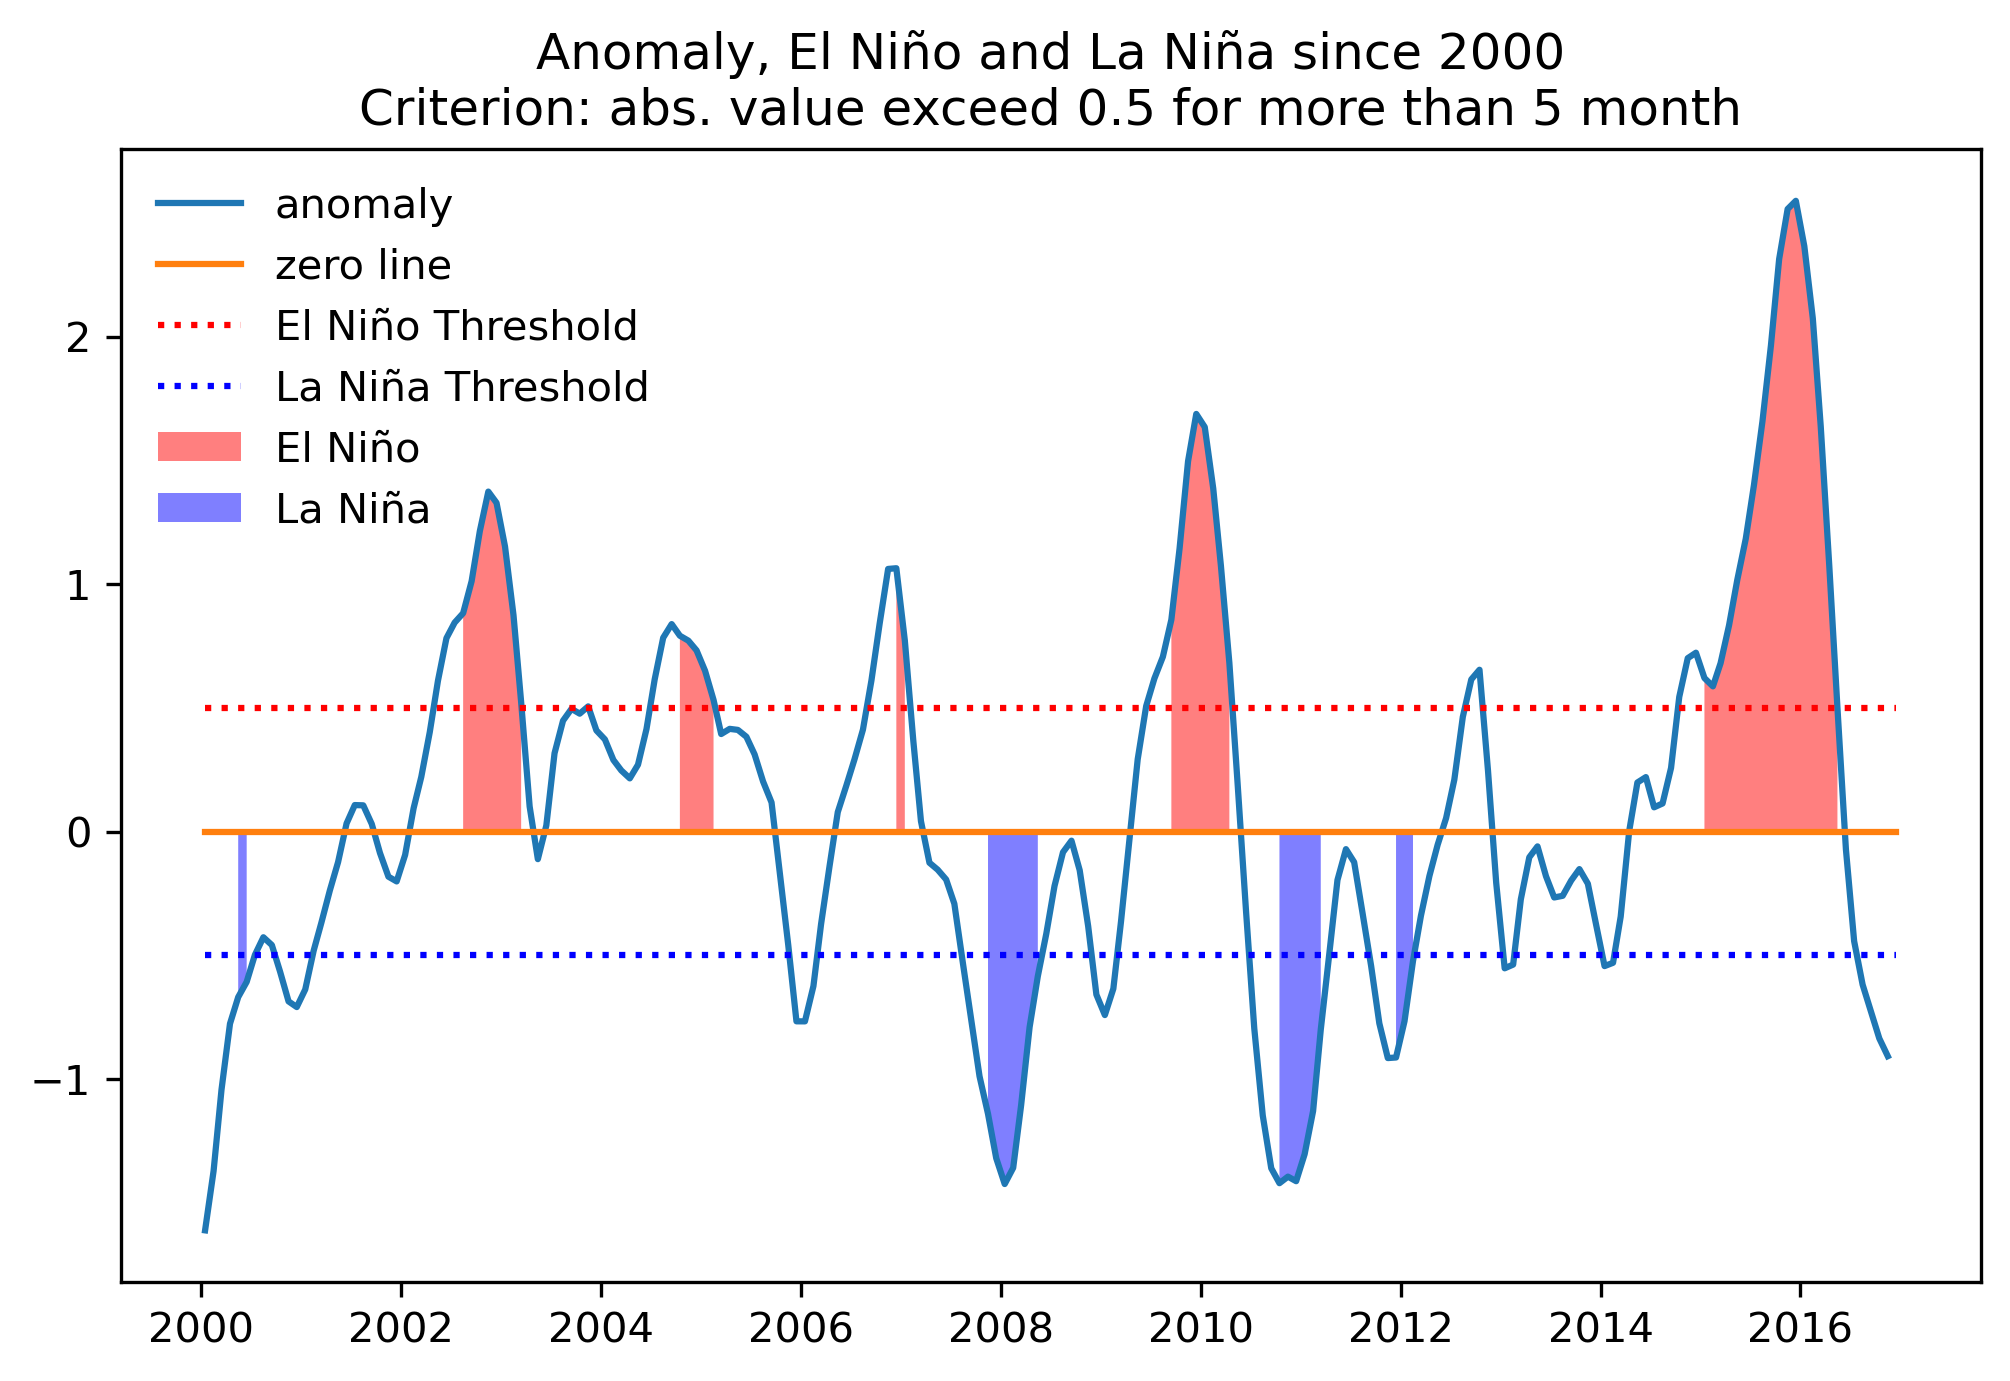

In [10]:
# 2.2
sst_anom_sel = sst_anom.sel(time=slice("2000-01", "2021-01"))
# find the position of El Nino and La Nina
# creation of logical-valued list
nino = [False for i in range(len(sst_anom_sel))]
nina = [False for i in range(len(sst_anom_sel))]
# set the criterion of nino and nina
ninoThresholdValue = 0.5
ninaThresholdValue = -0.5
ninoCriterion_monthlength = 5
# Use a naive linear algorithm to search
for i in range(len(sst_anom_sel)):
    if i>=4:
        ninoProduct = (sst_anom_sel[i] > ninoThresholdValue)
        ninaProduct = (sst_anom_sel[i] < ninaThresholdValue)
        for j in range(ninoCriterion_monthlength-1):
            ninoProduct = ninoProduct and (sst_anom_sel[i-j] > ninoThresholdValue)
            ninaProduct = ninaProduct and (sst_anom_sel[i-j] < ninaThresholdValue)
        nino[i] = ninoProduct
        nina[i] = ninaProduct
# plot
plt.figure(figsize=(8,5),dpi=300)
x = sst_anom_sel.time.values
y = sst_anom_sel.values
plt.plot(x, y)
ninoThreshold = [ninoThresholdValue for i in range(len(y))]
ninaThreshold = [ninaThresholdValue for i in range(len(y))]
zeroLine = [0 for i in range(len(y))]
plt.plot(x, zeroLine)
plt.plot(x, ninoThreshold,'r:')
plt.plot(x, ninaThreshold,'b:')
plt.fill_between(x, y, zeroLine, where=nino, alpha=0.5, facecolor = 'red')
plt.fill_between(x, y, zeroLine, where=nina, alpha=0.5, facecolor = 'blue')
plt.legend(['anomaly','zero line','El Niño Threshold','La Niña Threshold','El Niño', 'La Niña'],frameon=False)
plt.title('Anomaly, El Niño and La Niña since 2000\nCriterion: abs. value exceed 0.5 for more than 5 month')
plt.show()

In [11]:
# Q3 
# the dataset is NLDAS VIC Land Surface Model L4 Monthly 0.125 x 0.125 degree V002 (NLDAS_VIC0125_M)
# url: https://disc.gsfc.nasa.gov/datasets/NLDAS_VIC0125_M_002/summary?keywords=snow
# the downloaded data is separated in hundreds of files , with each one contains only one date point
# which we must merge into one xr.ds

# load the file contains all of the file names
fileNamesTxt = open('fileNames.txt')
# read the file name line by line
fileName = fileNamesTxt.readline().strip('\n')
# claim a var named data
data = xr.Dataset()
# read the data files and merge them into one xr.ds
# this algoriths is aceptable since the data is not large
while fileName:
    dataPoint = xr.open_dataset(fileName, engine='netcdf4')
    fileName = fileNamesTxt.readline().strip('\n')
    data = xr.merge([data,dataPoint])

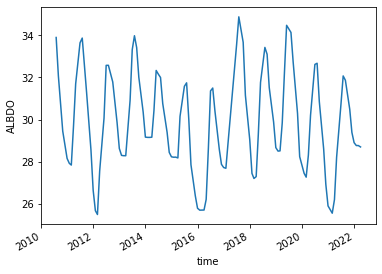

In [12]:
# 3.1 plot the deseasonalized time series
# method 1: rolling average
dataRolling = data.ALBDO.rolling(time=12, center=True).mean()
dataRolling.mean(dim=('lon', 'lat')).plot()

In [13]:
# method 2: seasonal_decompose function
# decompose the time series into three series:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(data.ALBDO.mean(dim=('lon', 'lat')), model="additive",period=12)

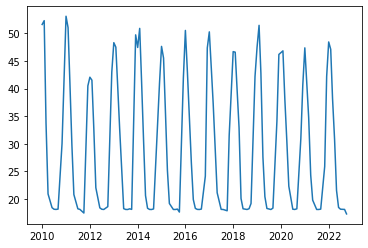

In [14]:
# the orginal tiime series
plt.plot(data.ALBDO.mean(dim=('lon', 'lat')).time,decompose_data.observed)

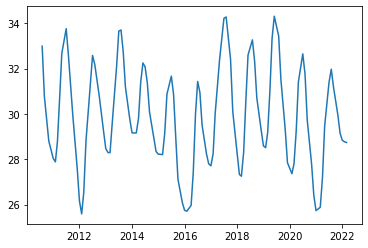

In [15]:
# the decomposed main trend
plt.plot(data.ALBDO.mean(dim=('lon', 'lat')).time,decompose_data.trend)

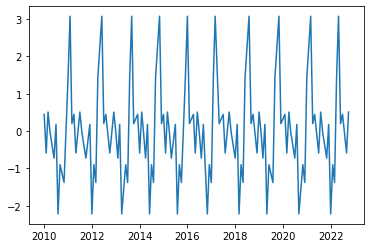

In [16]:
# the decomposed seasonal trend
plt.plot(data.ALBDO.mean(dim=('lon', 'lat')).time,decompose_data.seasonal)

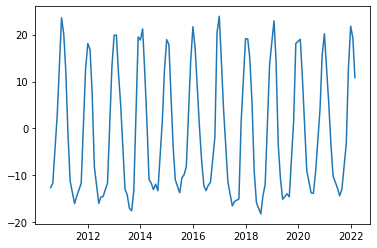

In [17]:
# the decomposed：noise
plt.plot(data.ALBDO.mean(dim=('lon', 'lat')).time,decompose_data.resid)

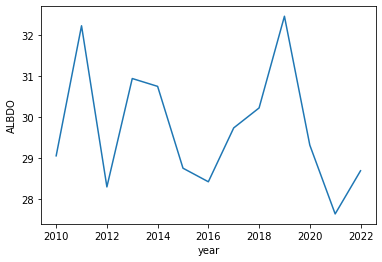

In [18]:
# method 3: yearly average
# this method is used in 
# Zhu, L., L. J. Mickley, D. J. Jacob,E. A. Marais, J. Sheng, L. Hu, G. G. Abad,and K. Chance (2017), Long-term (2005–2014) trends in formaldehyde
# (HCHO) columns across North America as seen by the OMI satellite instrument: Evidence of changing emissions of volatile organic compounds, Geophys.
# Res. Lett., 44, 7079–7086, doi:10.1002/2017GL073859.
data.ALBDO.groupby('time.year').mean(dim=('lon', 'lat','time')).plot()

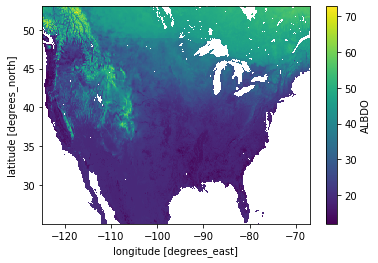

In [19]:
# 3.2 
# plot the averaged albdo
data.ALBDO.mean(dim=('time')).plot()

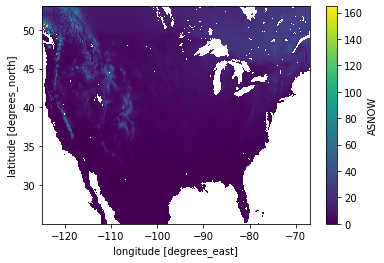

In [20]:
# plot the snow cover depth
data.ASNOW.mean(dim=('time')).plot()

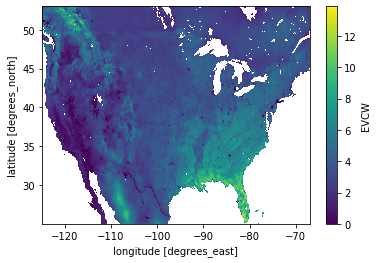

In [21]:
# plot EVCW
data.EVCW.mean(dim=('time')).plot()

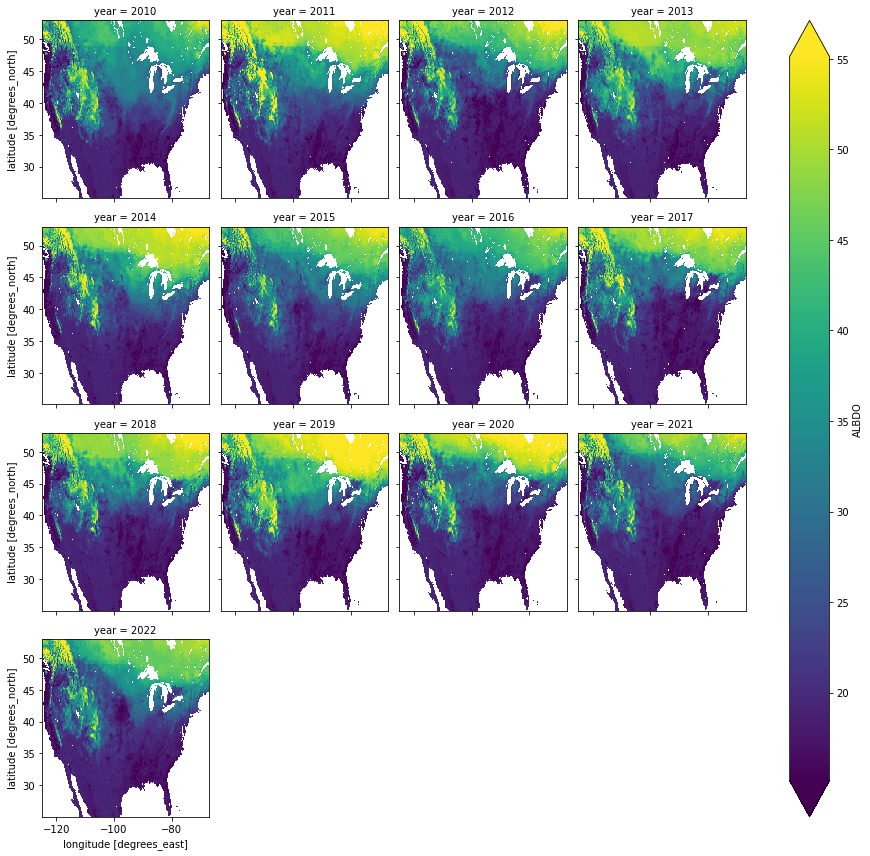

In [22]:
# plot yearly albdo
data.ALBDO.groupby('time.year').mean(dim=('time')).plot(col='year', col_wrap=4, robust=True)

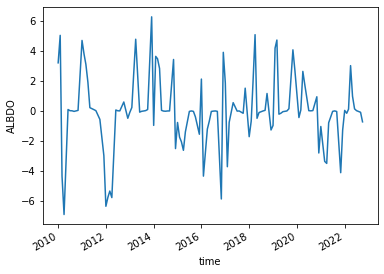

In [23]:
# plot the anomalies
albdoMonthlyGroups = data.ALBDO.mean(dim=('lon','lat')).groupby('time.month')
albdo_anom = albdoMonthlyGroups - albdoMonthlyGroups.mean(dim=('time'))
albdo_anom.plot()

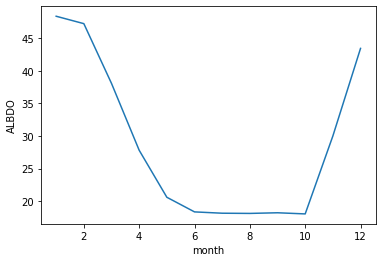

In [24]:
# plot the climatology of albdo
albdoMonthlyGroups.mean(dim=('time')).plot()

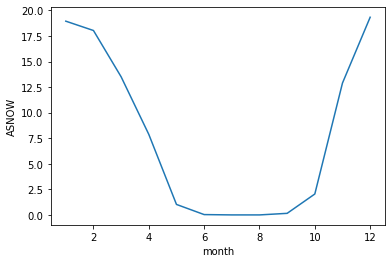

In [25]:
# plot the climatology of snow
data.ASNOW.mean(dim=('lon','lat')).groupby('time.month').mean(dim=('time')).plot()
# you may find that the albdo have a great correlation with snow